In [1]:
import numpy as np
import astrometry

In [2]:
import PyIndi
import time
import sys
import threading

In [3]:
class IndiClient(PyIndi.BaseClient):
    def __init__(self):
        super(IndiClient, self).__init__()
    def newDevice(self, d):
        pass
    def newProperty(self, p):
        pass
    def removeProperty(self, p):
        pass
    def newBLOB(self, bp):
        global blobEvent
        print("new BLOB ", bp.name)
        blobEvent.set()
        pass
    def newSwitch(self, svp):
        pass
    def newNumber(self, nvp):
        pass
    def newText(self, tvp):
        pass
    def newLight(self, lvp):
        pass
    def newMessage(self, d, m):
        pass
    def serverConnected(self):
        pass
    def serverDisconnected(self, code):
        pass


# connect the server
indiclient=IndiClient()
indiclient.setServer("indi-server",7624)

if (not(indiclient.connectServer())):
     print("No indiserver running on "+indiclient.getHost()+":"+str(indiclient.getPort())+" - Try to run")
     print("  indiserver indi_simulator_telescope indi_simulator_ccd")
     sys.exit(1)

# connect the scope
telescope="Telescope Simulator"
device_telescope=None
telescope_connect=None

# get the telescope device
device_telescope=indiclient.getDevice(telescope)
while not(device_telescope):
    time.sleep(0.5)
    device_telescope=indiclient.getDevice(telescope)
    
# wait CONNECTION property be defined for telescope
telescope_connect=device_telescope.getSwitch("CONNECTION")
while not(telescope_connect):
    time.sleep(0.5)
    telescope_connect=device_telescope.getSwitch("CONNECTION")

# if the telescope device is not connected, we do connect it
if not(device_telescope.isConnected()):
    # Property vectors are mapped to iterable Python objects
    # Hence we can access each element of the vector using Python indexing
    # each element of the "CONNECTION" vector is a ISwitch
    telescope_connect[0].s=PyIndi.ISS_ON  # the "CONNECT" switch
    telescope_connect[1].s=PyIndi.ISS_OFF # the "DISCONNECT" switch
    indiclient.sendNewSwitch(telescope_connect) # send this new value to the device
     
# Beware that ra/dec are in decimal hours/degrees
vega={'ra': (279.23473479 * 24.0)/360.0, 'dec': +89.15 }

# We want to set the ON_COORD_SET switch to engage tracking after goto
# device.getSwitch is a helper to retrieve a property vector
telescope_on_coord_set=device_telescope.getSwitch("ON_COORD_SET")
while not(telescope_on_coord_set):
    time.sleep(0.5)
    telescope_on_coord_set=device_telescope.getSwitch("ON_COORD_SET")
# the order below is defined in the property vector, look at the standard Properties page
# or enumerate them in the Python shell when you're developing your program
telescope_on_coord_set[0].s=PyIndi.ISS_ON  # TRACK
telescope_on_coord_set[1].s=PyIndi.ISS_OFF # SLEW
telescope_on_coord_set[2].s=PyIndi.ISS_OFF # SYNC
indiclient.sendNewSwitch(telescope_on_coord_set)
# We set the desired coordinates
telescope_radec=device_telescope.getNumber("EQUATORIAL_EOD_COORD")
while not(telescope_radec):
    time.sleep(0.5)
    telescope_radec=device_telescope.getNumber("EQUATORIAL_EOD_COORD")
telescope_radec[0].value=vega['ra']
telescope_radec[1].value=vega['dec']
indiclient.sendNewNumber(telescope_radec)
# and wait for the scope has finished moving
while (telescope_radec.s==PyIndi.IPS_BUSY):
    print("Scope Moving ", telescope_radec[0].value, telescope_radec[1].value)
    time.sleep(2)

# Let's take some pictures
ccd="CCD Simulator"
device_ccd=indiclient.getDevice(ccd)
while not(device_ccd):
    time.sleep(0.5)
    device_ccd=indiclient.getDevice(ccd)    

ccd_connect=device_ccd.getSwitch("CONNECTION")
while not(ccd_connect):
    time.sleep(0.5)
    ccd_connect=device_ccd.getSwitch("CONNECTION")
if not(device_ccd.isConnected()):
    ccd_connect[0].s=PyIndi.ISS_ON  # the "CONNECT" switch
    ccd_connect[1].s=PyIndi.ISS_OFF # the "DISCONNECT" switch
    indiclient.sendNewSwitch(ccd_connect)

ccd_exposure=device_ccd.getNumber("CCD_EXPOSURE")
while not(ccd_exposure):
    time.sleep(0.5)
    ccd_exposure=device_ccd.getNumber("CCD_EXPOSURE")

# Ensure the CCD simulator snoops the telescope simulator
# otherwise you may not have a picture of vega
ccd_active_devices=device_ccd.getText("ACTIVE_DEVICES")
while not(ccd_active_devices):
    time.sleep(0.5)
    ccd_active_devices=device_ccd.getText("ACTIVE_DEVICES")
ccd_active_devices[0].text="Telescope Simulator"
indiclient.sendNewText(ccd_active_devices)

# we should inform the indi server that we want to receive the
# "CCD1" blob from this device
indiclient.setBLOBMode(PyIndi.B_ALSO, ccd, "CCD1")

ccd_ccd1=device_ccd.getBLOB("CCD1")
while not(ccd_ccd1):
    time.sleep(0.5)
    ccd_ccd1=device_ccd.getBLOB("CCD1")

# a list of our exposure times
exposures=[3.0]

# we use here the threading.Event facility of Python
# we define an event for newBlob event
blobEvent=threading.Event()
blobEvent.clear()
i=0
ccd_exposure[0].value=exposures[i]
indiclient.sendNewNumber(ccd_exposure)
while (i < len(exposures)):
    # wait for the ith exposure
    blobEvent.wait()
    # we can start immediately the next one
    if (i + 1 < len(exposures)):
        ccd_exposure[0].value=exposures[i+1]
        blobEvent.clear()
        indiclient.sendNewNumber(ccd_exposure)
    # and meanwhile process the received one
    for blob in ccd_ccd1:
        print("name: ", blob.name," size: ", blob.size," format: ", blob.format)
        # pyindi-client adds a getblobdata() method to IBLOB item
        # for accessing the contents of the blob, which is a bytearray in Python
        fits=blob.getblobdata()
        print("fits data type: ", type(fits))
        # here you may use astropy.io.fits to access the fits data
        # and perform some computations while the ccd is exposing
        # but this is outside the scope of this tutorial
    i+=1

Scope Moving  18.615648986 89.15
new BLOB  CCD1
name:  CCD1  size:  2629440  format:  .fits
fits data type:  <class 'bytearray'>


In [4]:
from io import BytesIO
from astropy.io import fits
from matplotlib import pyplot as plt

In [5]:
fit1 = ccd_ccd1[0].getblobdata()
bi = BytesIO(fit1)
fss = fits.open(bi)
image_data = fss[0].data
fss.close()

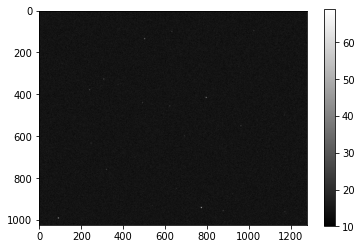

In [6]:
plt.imshow(image_data, cmap='gray')
plt.colorbar()

(array([1.30739e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.30744e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.31149e+05, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.31453e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.31071e+05, 0.00

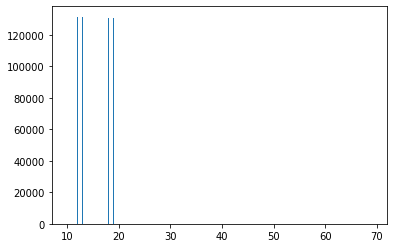

In [8]:
plt.hist(image_data.flatten(), 1000)

In [11]:
astrometry.